<h1>ANN changing learning rate optimization,using different loss function, different activation functions having different learning rates etc</h1>

In [249]:
import pandas as pd
import numpy as np


In [197]:
df = pd.read_csv('AMZN_2012-05-19_2025-04-06.csv')
df['date'] = pd.to_datetime(df['date'], utc=True)

print(df.head())
print(df.info())
print(df.describe())


                       date     open     high     low    close  adj_close  \
0 2012-05-21 04:00:00+00:00  10.7015  10.9990  10.641  10.9055    10.9055   
1 2012-05-22 04:00:00+00:00  10.9155  10.9435  10.698  10.7665    10.7665   
2 2012-05-23 04:00:00+00:00  10.7355  10.8775  10.559  10.8640    10.8640   
3 2012-05-24 04:00:00+00:00  10.8490  10.8830  10.635  10.7620    10.7620   
4 2012-05-25 04:00:00+00:00  10.7495  10.7990  10.611  10.6445    10.6445   

     volume  
0  71596000  
1  74662000  
2  84876000  
3  62822000  
4  43428000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3238 entries, 0 to 3237
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       3238 non-null   datetime64[ns, UTC]
 1   open       3238 non-null   float64            
 2   high       3238 non-null   float64            
 3   low        3238 non-null   float64            
 4   close      3238 non-null   flo

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3238 entries, 0 to 3237
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       3238 non-null   datetime64[ns, UTC]
 1   open       3238 non-null   float64            
 2   high       3238 non-null   float64            
 3   low        3238 non-null   float64            
 4   close      3238 non-null   float64            
 5   adj_close  3238 non-null   float64            
 6   volume     3238 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 177.2 KB


In [201]:
# Extract date parts
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

In [202]:
print(df.isnull().sum())
df.drop('date', axis=1, inplace=True)


date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
year         0
month        0
day          0
weekday      0
dtype: int64


In [203]:
df.duplicated().sum()

0

In [204]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


In [205]:
X = scaled_df.drop('close', axis=1)
y = scaled_df['close']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [231]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber
from tensorflow.keras.activations import relu, tanh, sigmoid, elu

def build_model(activation='relu', optimizer='adam', loss='mse', dropout_rate=0.2, use_batchnorm=True):
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],), activation=activation))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(32, activation=activation))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    return model


In [233]:
experiments = [
    {'name': 'M1', 'activation': 'relu',    'optimizer': Adam(learning_rate=0.001), 'loss': 'mse',   'dropout': 0.2, 'batchnorm': True},
    {'name': 'M2', 'activation': 'tanh',    'optimizer': SGD(learning_rate=0.01),   'loss': 'mae',   'dropout': 0.3, 'batchnorm': False},
    {'name': 'M3', 'activation': 'elu',     'optimizer': RMSprop(learning_rate=0.001), 'loss': Huber(), 'dropout': 0.1, 'batchnorm': True},
    {'name': 'M4', 'activation': 'sigmoid', 'optimizer': Adam(learning_rate=0.001), 'loss': 'mse',   'dropout': 0.5, 'batchnorm': True},
]



In [213]:
model2 = build_model(activation='tanh', optimizer=SGD(learning_rate=0.01), loss='mae', dropout_rate=0.3, use_batchnorm=False)


C:\Users\ahsan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [235]:
results = {}

for exp in experiments:
    print(f"Training {exp['name']}...")
    model = build_model(activation=exp['activation'],
                        optimizer=exp['optimizer'],
                        loss=exp['loss'],
                        dropout_rate=exp['dropout'],
                        use_batchnorm=exp['batchnorm'])
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_test, y_test), verbose=0)
    
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    results[exp['name']] = {
        'loss': loss,
        'mae': mae,
        'history': history.history
    }


Training M1...


C:\Users\ahsan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training M2...


C:\Users\ahsan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training M3...


C:\Users\ahsan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training M4...


C:\Users\ahsan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [239]:
for model_name, metrics in results.items():
    print(f"\nModel {model_name}")
    print(f"Loss: {metrics['loss']}")
    print(f"MAE:  {metrics['mae']}")



Model M1
Loss: 0.0001659034751355648
MAE:  0.010194849222898483

Model M2
Loss: 0.00800171960145235
MAE:  0.00800171960145235

Model M3
Loss: 0.00026301408070139587
MAE:  0.0171380415558815

Model M4
Loss: 0.0015144436620175838
MAE:  0.03428157418966293


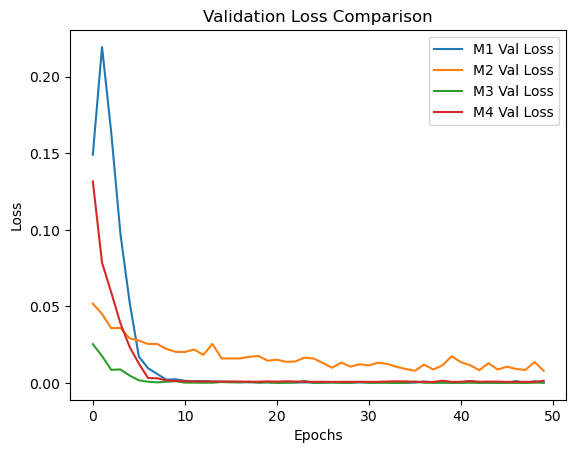

In [241]:
for model_name, metrics in results.items():
    plt.plot(metrics['history']['val_loss'], label=f'{model_name} Val Loss')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


<h1>M3 (ELU + RMSprop + Huber Loss + Dropout 0.1 + BatchNorm) performed the best overall with the lowest MAE and loss.</h1>